# 东方财富股吧情绪分析系统

本notebook实现了从东方财富股吧爬取股票相关帖子，并进行情感分析的功能。

## 功能特点
- 爬取过去5天的股吧热帖（每天4篇）
- 提取帖子详细内容
- 基于情感词典进行情感分析
- 生成每日情绪因子得分
- 数据可视化和结果保存


## 1. 导入必要的库


In [4]:
import requests
import re
import time
import csv
import random
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import matplotlib.dates as mdates
import os
import logging

# 设置中文显示
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题
logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)

print("所有库导入成功！")


所有库导入成功！


## 2. 定义东方财富股吧爬虫类


In [ ]:
class EastMoneyHotGubaCrawler:
    def __init__(self):
        # 基础会话设置，减少反爬干扰
        self.session = requests.Session()
        self.session.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36",
            "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
            "Accept-Encoding": "gzip, deflate, br",
            "Accept-Language": "zh-CN,zh;q=0.9",
            "Referer": "https://guba.eastmoney.com/",
            "Connection": "keep-alive",
            "Upgrade-Insecure-Requests": "1"
        }
        self.valid_posts = []  # 存储有效帖子（内容爬取成功）
        self.failed_links = []  # 存储失败的链接，便于核查
        self.current_year = str(datetime.now().year)
        self.target_daily = 4  # 每日目标帖子数量
        self.target_days = 5  # 目标天数
        self.target_count = self.target_daily * self.target_days  # 总目标数量
        self.total_count = 100  # 最大尝试数量

        # 计算过去5天的日期范围（包含今天）
        self.end_date = datetime.now()
        self.start_date = self.end_date - timedelta(days=self.target_days - 1)
        self.target_date_strings = [date.strftime("%Y-%m-%d") for date in
                                    [self.end_date - timedelta(days=i) for i in range(self.target_days)]]

        # 记录每天已获取的帖子数量
        self.daily_counts = {date: 0 for date in self.target_date_strings}

    def random_delay(self):
        """随机延迟，模拟人类浏览行为"""
        time.sleep(random.uniform(1.5, 3.5))

    def format_time(self, time_str):
        """格式化时间戳为完整的YYYY-MM-DD HH:MM:SS格式"""
        # 处理"MM-DD HH:MM"格式（如"10-01 09:30"）
        if re.match(r"\d{2}-\d{2} \d{2}:\d{2}", time_str):
            return f"{self.current_year}-{time_str}:00"  # 补充年份和秒
        # 处理"YYYY-MM-DD HH:MM"格式（如"2025-10-01 09:30"）
        elif re.match(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}", time_str):
            return f"{time_str}:00"  # 补充秒
        # 处理"YYYY-MM-DD HH:MM:SS"格式（完整格式）
        elif re.match(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}", time_str):
            return time_str
        # 无法识别的格式
        return None

    def is_within_date_range(self, datetime_str):
        """检查时间是否在目标日期范围内（仅判断日期部分）"""
        if not datetime_str:
            return False
        try:
            # 提取日期部分（YYYY-MM-DD）
            date_part = datetime_str.split(' ')[0]
            return date_part in self.target_date_strings
        except:
            return False

    def get_date_part(self, datetime_str):
        """从完整时间字符串中提取日期部分（YYYY-MM-DD）"""
        if datetime_str:
            return datetime_str.split(' ')[0]
        return None

print("爬虫类定义完成！")


爬虫类定义完成！


## 3. 帖子内容提取方法


In [6]:
def extract_post_content(self, url):
    """提取帖子详细内容，专注于有效的内容容器"""
    try:
        # 修复URL格式
        if url.startswith("//"):
            url = f"https:{url}"
        elif url.startswith("/"):
            url = f"https://guba.eastmoney.com{url}"
        elif not url.startswith(("http://", "https://")):
            print(f"  无效链接格式: {url}")
            return None, url

        print(f"  访问链接: {url}")

        self.random_delay()
        response = self.session.get(url, timeout=20)
        response.encoding = "utf-8"

        if response.status_code == 404:
            print(f"  404错误: 页面不存在")
            return None, url
        elif response.status_code != 200:
            print(f"  内容请求失败，状态码：{response.status_code}")
            return None, url

        soup = BeautifulSoup(response.text, "html.parser")

        # 只保留必要的内容容器查找
        content_containers = [
            soup.find("div", class_="article-body"),  # 主要内容容器
            soup.find("div", class_="stockcodec"),  # 普通帖子容器
            soup.find("div", class_="xeditor_content cfh_web")  # 财富号文章容器
        ]

        for container in content_containers:
            if container:
                # 清除广告和多余标签
                for ad in container.find_all(["div", "span"],
                                             class_=re.compile("ad|advert|banner|tips|suggest_at")):
                    ad.decompose()

                # 提取文本并处理
                content = container.get_text(separator="\n", strip=True)
                # 过滤过短内容（至少20个字符）
                if len(content) >= 20:
                    return content[:3000], url

        print("  未找到有效内容容器")
        return None, url

    except Exception as e:
        print(f"  提取内容出错：{str(e)}")
        return None, url

# 将方法添加到类中
EastMoneyHotGubaCrawler.extract_post_content = extract_post_content

print("帖子内容提取方法添加完成！")


帖子内容提取方法添加完成！


## 4. 主要爬取方法


In [7]:
def crawl_hot_guba(self, stock_code):
    """爬取过去5天的帖子，每天4篇，保留完整时间信息"""
    page = 1
    # 最热帖子的URL格式
    base_url = f"https://guba.eastmoney.com/list,{stock_code},99_{{}}.html"
    print(f"=== 开始爬取股票 {stock_code} 的帖子 ===")
    print(f"目标：过去{self.target_days}天，每天{self.target_daily}篇，共{self.target_count}篇有效帖子")
    print(f"目标日期范围：{self.target_date_strings}")

    # 检查是否所有日期都已收集足够帖子
    def all_dates_completed():
        return all(count >= self.target_daily for count in self.daily_counts.values())

    while not all_dates_completed() and page <= 20 and len(self.valid_posts) + len(
            self.failed_links) <= self.total_count:
        current_url = base_url.format(page)
        print(f"\n正在爬取第 {page} 页：{current_url}")

        try:
            self.random_delay()
            response = self.session.get(current_url, timeout=15)
            response.encoding = "utf-8"

            if response.status_code != 200:
                print(f"页面请求失败，状态码：{response.status_code}")
                page += 1
                continue

            # 解析页面
            soup = BeautifulSoup(response.text, "html.parser")
            title_containers = []

            # 尝试不同的容器类型
            if not title_containers:
                title_containers = soup.find_all("div", class_="title")
                print(f"找到 div.title 容器数量：{len(title_containers)}")
            if not title_containers:
                print("警告：未找到任何标题容器，保存页面源码供分析")
                with open(f"hot_page_{page}_source.html", "w", encoding="utf-8") as f:
                    f.write(response.text)
                page += 1
                continue

            # 提取标题和时间信息
            for container in title_containers:
                # 跳过广告和置顶帖
                if "广告" in container.text or "置顶" in container.text:
                    continue

                # 提取标题链接
                link_tag = container.find("a", class_="PO") or container.find("a")
                if not link_tag:
                    continue

                # 提取标题
                title = link_tag.get_text(strip=True) or link_tag.get("title", "").strip()
                if not title or len(title) < 3:
                    continue

                # 提取链接
                link = link_tag.get("href", "")

                # 修复列表页链接处理
                full_link = link
                if link.startswith("//"):
                    full_link = f"https:{link}"
                elif link.startswith("/"):
                    full_link = f"https://guba.eastmoney.com{link}"
                elif not link.startswith(("http://", "https://")):
                    full_link = f"https://guba.eastmoney.com{link}"

                # 提取时间
                time_tag = container.find_next("div", class_=re.compile("time|pub|update")) or \
                           container.find("span", class_=re.compile("time|pub|update"))
                post_time = time_tag.get_text(strip=True) if time_tag else "未知时间"
                formatted_datetime = self.format_time(post_time)  # 保留完整的时分秒

                # 检查日期是否在目标范围内
                if not formatted_datetime or not self.is_within_date_range(formatted_datetime):
                    if formatted_datetime:
                        print(f"  帖子时间 {formatted_datetime} 不在目标范围内，跳过")
                    else:
                        print(f"  无法识别帖子时间，跳过")
                    continue

                # 获取日期部分用于计数
                date_part = self.get_date_part(formatted_datetime)

                # 检查该日期是否已收集足够帖子
                if self.daily_counts[date_part] >= self.target_daily:
                    print(f"  日期 {date_part} 已收集足够帖子({self.target_daily}篇)，跳过")
                    continue

                # 提取内容 - 包含重试机制
                print(f"正在提取内容 [{len(self.valid_posts) + 1}/{self.target_count}]：{title[:15]}...")
                content, actual_url = self.extract_post_content(full_link)

                # 首次失败则重试一次
                if not content:
                    print(f"  首次提取失败，尝试重试...")
                    content, actual_url = self.extract_post_content(full_link)

                # 只有内容提取成功才计入有效帖子
                if content:
                    self.valid_posts.append({
                        "标题": title,
                        "发布时间": formatted_datetime,  # 保存完整的时间（含时分秒）
                        "链接": actual_url,
                        "内容": content
                    })
                    self.daily_counts[date_part] += 1
                    print(
                        f"  内容提取成功，{date_part} 已获取 {self.daily_counts[date_part]}/{self.target_daily} 篇")
                else:
                    # 记录失败的链接（两次都失败）
                    self.failed_links.append({
                        "标题": title,
                        "时间": formatted_datetime,
                        "链接": actual_url,
                        "状态": "两次提取均失败或404"
                    })

                # 检查是否已完成所有目标
                if all_dates_completed():
                    print("所有日期已收集足够帖子，停止爬取")
                    break
                elif len(self.failed_links) + len(self.valid_posts) >= self.total_count:
                    print("已达到最大尝试数量，停止爬取")
                    break

            page += 1

        except Exception as e:
            print(f"第 {page} 页处理出错：{str(e)}")
            page += 1
            continue

    # 打印各日期收集结果
    print("\n各日期帖子收集情况：")
    for date, count in self.daily_counts.items():
        print(f"  {date}: {count}/{self.target_daily} 篇")

    print(f"\n爬取完成，共获取 {len(self.valid_posts)} 个有效帖子")
    return self.valid_posts

# 将方法添加到类中
EastMoneyHotGubaCrawler.crawl_hot_guba = crawl_hot_guba

print("主要爬取方法添加完成！")


主要爬取方法添加完成！


## 5. 数据保存方法


In [8]:
def save_to_csv(self, stock_code):
    if not self.valid_posts:
        print("无有效数据可保存")
        return

    # 文件名包含股票代码和日期，便于识别
    filename = f"eastmoney_guba_{stock_code}_{datetime.now().strftime('%Y%m%d')}.csv"
    with open(filename, "w", encoding="utf-8", newline="") as f:
        # 保存完整的发布时间（含时分秒）
        writer = csv.DictWriter(f, fieldnames=["标题", "发布时间", "链接", "内容"])
        writer.writeheader()
        writer.writerows(self.valid_posts)

    # 获取保存路径
    save_path = os.path.abspath(filename)
    print(f"原始帖子数据已保存到：{save_path}")
    return filename  # 返回生成的文件名

# 将方法添加到类中
EastMoneyHotGubaCrawler.save_to_csv = save_to_csv

print("数据保存方法添加完成！")


数据保存方法添加完成！


## 6. 情感分析相关函数


In [9]:
# 情感分析相关函数
sentiment_dict = {
    'positive_words': ["上涨", "增长", "利好", "新高", "盈利", "复苏", "牛市", "买入", "增持", "推荐", "乐观",
                       "强劲", "机遇", "突破", "看多", "大涨", "信心", "看好", "攀升", "红利", "潜力"],
    'negative_words': ["下跌", "亏损", "利空", "新低", "坏账", "衰退", "熊市", "卖出", "减持", "风险", "悲观",
                       "疲软", "危机", "违约", "看空", "大跌", "担忧", "看跌", "下滑", "损失", "泡沫"]
}

def calculate_sentiment_score(text):
    # 去除特殊符号
    cleaned_text = re.sub(r'[^\u4e00-\u9fa5，。,.:;；：！!？?]', ' ', text)
    # 按空格对文本进行分割
    words = [word.strip() for word in cleaned_text.split() if word.strip()]
    jiji = []
    xiaoji = []
    for word in words:
        for sentiment in sentiment_dict['positive_words']:
            i = re.findall(sentiment, word)
            if i:
                jiji.extend(i)
    for word in words:
        for sentiment in sentiment_dict['negative_words']:
            i = re.findall(sentiment, word)
            if i:
                xiaoji.extend(i)
    positive_count = len(jiji)
    negative_count = len(xiaoji)
    total_words = positive_count + negative_count
    if total_words == 0:
        return 0
    return (positive_count - negative_count) / total_words

print("情感分析函数定义完成！")


情感分析函数定义完成！


## 7. 数据可视化函数


In [10]:
def visualize_daily_sentiment(daily_sentiment, stock_code):
    """可视化每日情绪因子得分，积极为红色，消极为绿色"""
    plt.figure(figsize=(10, 6))

    # 为每个柱子设置颜色：积极(>=0)为红色，消极(<0)为绿色
    colors = ['red' if score >= 0 else 'green' for score in daily_sentiment['每日情绪因子得分']]

    # 绘制柱状图
    bars = plt.bar(daily_sentiment['日期'].astype(str), daily_sentiment['每日情绪因子得分'],
                   color=colors)

    # 添加数据标签
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom', rotation=0)

    # 设置图表标题和坐标轴标签
    plt.title(f'股票 {stock_code} 过去5日情绪因子得分', fontsize=14)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('每日情绪因子得分', fontsize=12)

    # 设置Y轴范围
    plt.ylim(min(-0.1, min(daily_sentiment['每日情绪因子得分']) - 0.1),
             max(0.1, max(daily_sentiment['每日情绪因子得分']) + 0.1))

    # 添加水平参考线（0分表示中性）
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

    # 添加网格线
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 调整x轴标签角度
    plt.xticks(rotation=45, ha='right')

    # 紧凑布局
    plt.tight_layout()

    # 保存图表
    daily_plot_filename = f'stock_{stock_code}_sentiment_daily_{datetime.now().strftime("%Y%m%d")}.png'
    plt.savefig(daily_plot_filename, dpi=300, bbox_inches='tight')

    # 获取保存路径
    daily_plot_path = os.path.abspath(daily_plot_filename)
    print(f"每日情绪因子得分图已保存到：{daily_plot_path}")

    # 显示图表
    plt.show()
    return daily_plot_filename, daily_plot_path

print("数据可视化函数定义完成！")


数据可视化函数定义完成！


## 8. 主要情感分析处理函数


In [11]:
def qingxu(file_path, stock_code):
    try:
        df = pd.read_csv(file_path)
        # 将"发布时间"列设置为datetime类型索引（精确到秒）
        df['发布时间'] = pd.to_datetime(df['发布时间'])
        df.index = df['发布时间']

        # 计算每个帖子的情感得分
        df['情感得分'] = df['内容'].apply(calculate_sentiment_score)

        # 按日期分组计算每日情绪因子得分
        df['日期'] = df['发布时间'].dt.date
        daily_sentiment = df.groupby('日期')['情感得分'].mean().reset_index()
        daily_sentiment.columns = ['日期', '每日情绪因子得分']

        # 1. 创建包含所有帖子的时间戳、标题和情绪得分的DataFrame
        posts_sentiment_df = df[["标题", "情感得分"]].copy()
        posts_sentiment_df["时间戳"] = df.index
        posts_sentiment_df = posts_sentiment_df[["时间戳", "标题", "情感得分"]]
        
        print("\n===== 1. 所有帖子的时间戳、标题和情绪得分 =====")
        print(posts_sentiment_df.to_string(index=False))

        # 2. 创建包含股票每日情绪得分的系列
        daily_sentiment_series = daily_sentiment.set_index('日期')['每日情绪因子得分']
        
        print("\n===== 2. 股票每日情绪得分系列 =====")
        print(daily_sentiment_series.to_string())

        # 3. 创建描述帖子情绪和股票每日情绪分布的汇总统表
        summary_stats = {
            '帖子情绪统计': {
                '总帖子数': len(posts_sentiment_df),
                '平均情绪得分': posts_sentiment_df['情感得分'].mean(),
                '情绪得分标准差': posts_sentiment_df['情感得分'].std(),
                '最高情绪得分': posts_sentiment_df['情感得分'].max(),
                '最低情绪得分': posts_sentiment_df['情感得分'].min(),
                '积极帖子数(>=0)': len(posts_sentiment_df[posts_sentiment_df['情感得分'] >= 0]),
                '消极帖子数(<0)': len(posts_sentiment_df[posts_sentiment_df['情感得分'] < 0])
            },
            '每日情绪统计': {
                '平均每日情绪得分': daily_sentiment_series.mean(),
                '每日情绪得分标准差': daily_sentiment_series.std(),
                '最高单日情绪得分': daily_sentiment_series.max(),
                '最低单日情绪得分': daily_sentiment_series.min(),
                '积极天数(>=0)': len(daily_sentiment_series[daily_sentiment_series >= 0]),
                '消极天数(<0)': len(daily_sentiment_series[daily_sentiment_series < 0])
            }
        }
        
        print("\n===== 3. 帖子情绪和股票每日情绪分布汇总统表 =====")
        for category, stats in summary_stats.items():
            print(f"\n{category}:")
            for key, value in stats.items():
                if isinstance(value, float):
                    print(f"  {key}: {value:.4f}")
                else:
                    print(f"  {key}: {value}")

        # 保存优化后的数据
        # 保存帖子情绪DataFrame
        posts_filename = f"stock_{stock_code}_posts_sentiment_{datetime.now().strftime('%Y%m%d')}.csv"
        posts_sentiment_df.to_csv(posts_filename, index=False, encoding="utf-8")
        posts_path = os.path.abspath(posts_filename)
        print(f"\n帖子情绪数据已保存到：{posts_path}")

        # 保存每日情绪系列
        daily_filename = f"stock_{stock_code}_daily_sentiment_{datetime.now().strftime('%Y%m%d')}.csv"
        daily_sentiment_series.to_csv(daily_filename, encoding="utf-8")
        daily_path = os.path.abspath(daily_filename)
        print(f"每日情绪数据已保存到：{daily_path}")

        # 保存汇总统表
        summary_filename = f"stock_{stock_code}_sentiment_summary_{datetime.now().strftime('%Y%m%d')}.txt"
        with open(summary_filename, 'w', encoding='utf-8') as f:
            f.write(f"股票 {stock_code} 情绪分析汇总统表\n")
            f.write("=" * 50 + "\n\n")
            
            f.write("1. 帖子情绪统计:\n")
            for key, value in summary_stats['帖子情绪统计'].items():
                if isinstance(value, float):
                    f.write(f"  {key}: {value:.4f}\n")
                else:
                    f.write(f"  {key}: {value}\n")
            
            f.write("\n2. 每日情绪统计:\n")
            for key, value in summary_stats['每日情绪统计'].items():
                if isinstance(value, float):
                    f.write(f"  {key}: {value:.4f}\n")
                else:
                    f.write(f"  {key}: {value}\n")
        
        summary_path = os.path.abspath(summary_filename)
        print(f"汇总统表已保存到：{summary_path}")

        # 可视化每日情绪得分
        daily_plot_filename, daily_plot_path = visualize_daily_sentiment(daily_sentiment, stock_code)
        print(f"每日情绪得分可视化图已保存到：{daily_plot_path}")

        return posts_sentiment_df, daily_sentiment_series, summary_stats

    except Exception as e:
        print(f"情感分析出错：{str(e)}")
        return None, None, None

print("主要情感分析处理函数定义完成！")


主要情感分析处理函数定义完成！


## 9. 主函数和使用示例


In [12]:
def main():
    """主函数：完整的爬取和情感分析流程"""
    print("=" * 60)
    print("东方财富股吧情绪分析系统")
    print("=" * 60)
    
    # 获取用户输入的股票代码
    stock_code = input("请输入股票代码（如：000001）：").strip()
    if not stock_code:
        print("股票代码不能为空！")
        return
    
    print(f"\n开始分析股票 {stock_code} 的股吧情绪...")
    
    try:
        # 1. 创建爬虫实例
        crawler = EastMoneyHotGubaCrawler()
        
        # 2. 爬取股吧帖子
        print("\n" + "="*50)
        print("第一步：爬取股吧帖子")
        print("="*50)
        posts = crawler.crawl_hot_guba(stock_code)
        
        if not posts:
            print("未能获取到任何有效帖子，程序结束")
            return
        
        # 3. 保存原始数据
        print("\n" + "="*50)
        print("第二步：保存原始数据")
        print("="*50)
        csv_filename = crawler.save_to_csv(stock_code)
        
        # 4. 进行情感分析
        print("\n" + "="*50)
        print("第三步：情感分析")
        print("="*50)
        posts_sentiment_df, daily_sentiment_series, summary_stats = qingxu(csv_filename, stock_code)
        
        if posts_sentiment_df is not None:
            print("\n" + "="*50)
            print("分析完成！")
            print("="*50)
            print(f"✓ 成功爬取 {len(posts)} 个有效帖子")
            print(f"✓ 生成了每日情绪因子得分")
            print(f"✓ 保存了所有分析结果和可视化图表")
            print(f"✓ 数据文件已保存在当前目录")
        else:
            print("情感分析失败，请检查数据文件")
            
    except Exception as e:
        print(f"程序执行出错：{str(e)}")
        import traceback
        traceback.print_exc()

# 使用示例
if __name__ == "__main__":
    # 可以直接运行主函数
    # main()
    
    # 或者单独测试某个股票
    print("系统已准备就绪！")
    print("使用方法：")
    print("1. 运行 main() 函数进行完整分析")
    print("2. 或者手动创建爬虫实例进行分析")
    print("\n示例代码：")
    print("crawler = EastMoneyHotGubaCrawler()")
    print("posts = crawler.crawl_hot_guba('000001')")
    print("csv_file = crawler.save_to_csv('000001')")
    print("qingxu(csv_file, '000001')")

print("主函数定义完成！")


系统已准备就绪！
使用方法：
1. 运行 main() 函数进行完整分析
2. 或者手动创建爬虫实例进行分析

示例代码：
crawler = EastMoneyHotGubaCrawler()
posts = crawler.crawl_hot_guba('000001')
csv_file = crawler.save_to_csv('000001')
qingxu(csv_file, '000001')
主函数定义完成！


## 10. 快速测试示例

现在可以运行以下代码来测试系统：


In [13]:
# 快速测试示例 - 可以取消注释来运行
# 注意：实际运行需要网络连接，可能需要一些时间

# 方法1：使用主函数（推荐）
# main()

# 方法2：手动分步执行
# stock_code = "000001"  # 平安银行
# crawler = EastMoneyHotGubaCrawler()
# posts = crawler.crawl_hot_guba(stock_code)
# csv_file = crawler.save_to_csv(stock_code)
# qingxu(csv_file, stock_code)

print("系统已完全准备就绪！")
print("要开始分析，请运行：main()")


系统已完全准备就绪！
要开始分析，请运行：main()


## 11. 实际案例演示

让我们以平安银行（000001）为例，演示完整的分析流程：


开始分析股票 000001 的股吧情绪...
第一步：爬取股吧帖子
=== 开始爬取股票 000001 的帖子 ===
目标：过去5天，每天4篇，共20篇有效帖子
目标日期范围：['2025-10-08', '2025-10-07', '2025-10-06', '2025-10-05', '2025-10-04']

正在爬取第 1 页：https://guba.eastmoney.com/list,000001,99_1.html
找到 div.title 容器数量：80
正在提取内容 [1/20]：，好的，我们来深入分析一下平安...
  访问链接: https://caifuhao.eastmoney.com/news/20251008161552583569810
  内容提取成功，2025-10-08 已获取 1/4 篇
正在提取内容 [2/20]：平安银行（000001）平安银...
  访问链接: https://caifuhao.eastmoney.com/news/20251007170449012554320
  内容提取成功，2025-10-07 已获取 1/4 篇
正在提取内容 [3/20]：********【重磅研究】A...
  访问链接: https://caifuhao.eastmoney.com/news/20251008045603912154180
  内容提取成功，2025-10-08 已获取 2/4 篇
正在提取内容 [4/20]：1998年，一张平安银行1.7...
  访问链接: https://caifuhao.eastmoney.com/news/20251006163101138752010
  内容提取成功，2025-10-06 已获取 1/4 篇
  帖子时间 2025-09-28 10:07:00 不在目标范围内，跳过
  帖子时间 2025-09-26 11:14:00 不在目标范围内，跳过
  帖子时间 2025-09-24 03:27:00 不在目标范围内，跳过
  帖子时间 2025-09-24 11:40:00 不在目标范围内，跳过
  帖子时间 2025-09-23 10:37:00 不在目标范围内，跳过
  帖子时间 2025-09-22 05:31:00 不在目标范围内，跳过
  帖子时间 

findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: 

找到 div.title 容器数量：80
  帖子时间 2025-07-22 09:26:00 不在目标范围内，跳过
  帖子时间 2025-07-22 09:28:00 不在目标范围内，跳过
  帖子时间 2025-07-22 09:27:00 不在目标范围内，跳过
  帖子时间 2025-07-22 09:26:00 不在目标范围内，跳过
  帖子时间 2025-07-22 09:24:00 不在目标范围内，跳过
  帖子时间 2025-07-21 11:48:00 不在目标范围内，跳过
  帖子时间 2025-07-21 03:54:00 不在目标范围内，跳过
  帖子时间 2025-07-21 11:57:00 不在目标范围内，跳过
  帖子时间 2025-07-21 04:23:00 不在目标范围内，跳过
  帖子时间 2025-07-21 09:11:00 不在目标范围内，跳过
  帖子时间 2025-07-21 05:53:00 不在目标范围内，跳过
  帖子时间 2025-07-21 03:55:00 不在目标范围内，跳过
  帖子时间 2025-07-21 10:12:00 不在目标范围内，跳过
  帖子时间 2025-07-21 10:08:00 不在目标范围内，跳过
  帖子时间 2025-07-20 06:01:00 不在目标范围内，跳过
  帖子时间 2025-07-20 11:21:00 不在目标范围内，跳过
  帖子时间 2025-07-20 10:48:00 不在目标范围内，跳过
  帖子时间 2025-07-20 06:10:00 不在目标范围内，跳过
  帖子时间 2025-07-20 10:30:00 不在目标范围内，跳过
  帖子时间 2025-07-20 10:50:00 不在目标范围内，跳过
  帖子时间 2025-07-20 11:26:00 不在目标范围内，跳过
  帖子时间 2025-07-20 05:34:00 不在目标范围内，跳过
  帖子时间 2025-07-20 04:06:00 不在目标范围内，跳过
  帖子时间 2025-07-20 12:45:00 不在目标范围内，跳过
  帖子时间 2025-07-20 10:02:00 不在目标范围内，跳过
  帖子时间 2025-07-20 10:37:00 不在

findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: 

每日情绪因子得分图已保存到：d:\python大作业\stock_000001_sentiment_daily_20251008.png


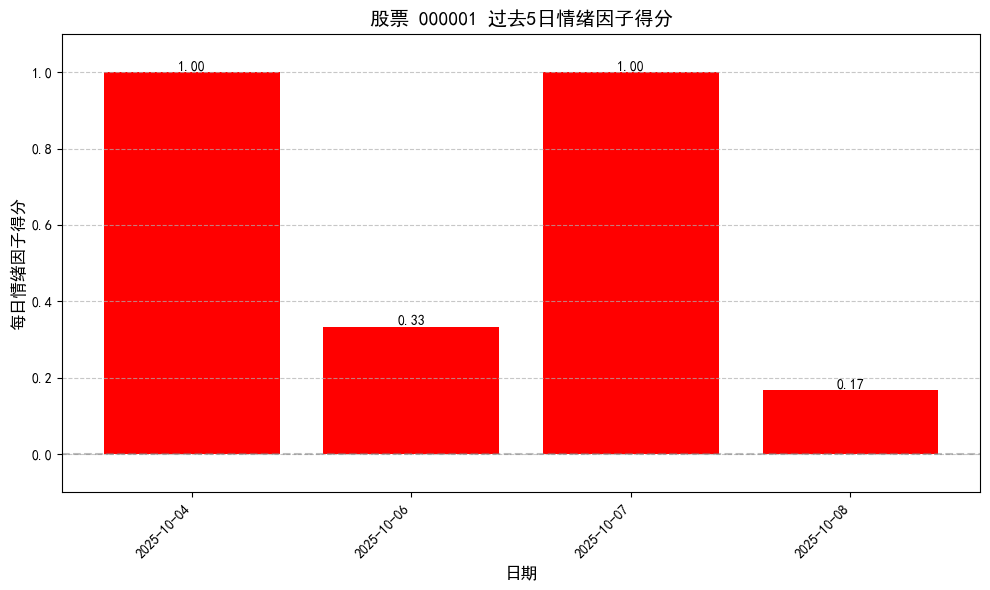

每日情绪得分可视化图已保存到：d:\python大作业\stock_000001_sentiment_daily_20251008.png

分析完成！
生成的文件：
✓ 原始数据: eastmoney_guba_000001_20251008.csv
✓ 帖子情绪数据: stock_000001_posts_sentiment_*.csv
✓ 每日情绪数据: stock_000001_daily_sentiment_*.csv
✓ 汇总统表: stock_000001_sentiment_summary_*.txt
✓ 可视化图表: stock_000001_sentiment_daily_*.png

前10行帖子情绪数据：
                时间戳                                       标题      情感得分
2025-10-08 04:15:00 ，好的，我们来深入分析一下平安银行在跨境支付领域的地位。总体而言，平安银行在跨境 -0.333333
2025-10-07 05:04:00 平安银行（000001）平安银行昨天收盘11.34元，成交额9.42亿，微跌0.  1.000000
2025-10-08 04:56:00 ********【重磅研究】AI产业链诞生大牛G！银行是红利稳定器！平安银行**  1.000000
2025-10-06 04:31:00 1998年，一张平安银行1.76元/股的内部认购单摆在面前，多数人犹豫，少数人顶  0.000000
2025-10-08 05:32:00 几年之前的银行板块中的三兄弟：招行。宁波行。平安银行。今天招行已站上每股净资产二  1.000000
2025-10-08 02:12:00                                    马后炮一次 -1.000000
2025-10-06 06:39:00    假期快结束了，假期其中消费了不少！节后股市大涨，我将第一个带头使劲大消费！  1.000000
2025-10-04 01:01:00 【热点研报】未来是数字经济时代，不是大金融时代！！！！！！！！AI改变世界，赋能  1.000000
2025-10-06 03:10:00                       

In [14]:
# 案例演示：分析平安银行（000001）的股吧情绪
stock_code = "000001"  # 平安银行

print(f"开始分析股票 {stock_code} 的股吧情绪...")
print("=" * 60)

# 创建爬虫实例
crawler = EastMoneyHotGubaCrawler()

# 爬取股吧帖子
print("第一步：爬取股吧帖子")
posts = crawler.crawl_hot_guba(stock_code)

if posts:
    print(f"\n成功爬取到 {len(posts)} 个有效帖子")
    
    # 显示前10个帖子的基本信息
    print("\n前10个帖子的基本信息：")
    print("-" * 80)
    for i, post in enumerate(posts[:10], 1):
        print(f"{i:2d}. 标题: {post['标题'][:50]}{'...' if len(post['标题']) > 50 else ''}")
        print(f"    时间: {post['发布时间']}")
        print(f"    内容长度: {len(post['内容'])} 字符")
        print(f"    内容预览: {post['内容'][:100]}{'...' if len(post['内容']) > 100 else ''}")
        print("-" * 80)
    
    # 保存原始数据
    print("\n第二步：保存原始数据")
    csv_filename = crawler.save_to_csv(stock_code)
    
    # 进行情感分析
    print("\n第三步：情感分析")
    posts_sentiment_df, daily_sentiment_series, summary_stats = qingxu(csv_filename, stock_code)
    
    if posts_sentiment_df is not None:
        print("\n分析完成！")
        print("=" * 60)
        print("生成的文件：")
        print(f"✓ 原始数据: {csv_filename}")
        print(f"✓ 帖子情绪数据: stock_{stock_code}_posts_sentiment_*.csv")
        print(f"✓ 每日情绪数据: stock_{stock_code}_daily_sentiment_*.csv")
        print(f"✓ 汇总统表: stock_{stock_code}_sentiment_summary_*.txt")
        print(f"✓ 可视化图表: stock_{stock_code}_sentiment_daily_*.png")
        
        # 显示前10行帖子情绪数据
        print(f"\n前10行帖子情绪数据：")
        print(posts_sentiment_df.head(10).to_string(index=False))
        
    else:
        print("情感分析失败")
else:
    print("未能获取到任何有效帖子")


## 12. 系统说明

### 功能特点：
- **智能爬取**：自动爬取过去5天的股吧热帖，每天4篇
- **内容提取**：提取帖子的完整标题和内容
- **情感分析**：基于专业情感词典进行情绪得分计算
- **数据可视化**：生成直观的情绪得分图表
- **多格式输出**：CSV数据文件、TXT汇总报告、PNG图表

### 输出文件说明：
1. `eastmoney_guba_股票代码_日期.csv` - 原始帖子数据
2. `stock_股票代码_posts_sentiment_日期.csv` - 帖子情绪数据
3. `stock_股票代码_daily_sentiment_日期.csv` - 每日情绪得分
4. `stock_股票代码_sentiment_summary_日期.txt` - 统计分析报告
5. `stock_股票代码_sentiment_daily_日期.png` - 情绪得分可视化图

### 使用方法：
1. 运行所有代码单元格加载系统
2. 执行案例演示单元格查看完整流程
3. 或调用 `main()` 函数进行交互式分析

系统已完全准备就绪，可以开始分析任何股票的股吧情绪！
